## Import and setup of custom helper functions

Just a quick step to import libraries and define convenience functions that simplify data manipulation, renaming columns, etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter 
import datetime as dt
import shap

pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',100)
pd.set_option('display.width', 500)


def string_to_date(datestr, dt_format="%m/%y"):
    return dt.datetime.strptime(datestr, dt_format)

def date_diff(start_date, end_date):
    return (end_date-start_date).days

def redo_colnames(colnames, level=0):
    newnames = []
    if isinstance(colnames, pd.MultiIndex):
        for col in colnames:
            newnames.append(col[level].replace('_',' ').capitalize())
    else:
        for col in colnames:
            newnames.append(col.repalce('_',' ').capitalize())
    return newnames

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'p%s' % n
    return percentile_

def spd(sensitive_attribute, dataset, predicted_labels, majority_class, minority_class):
    # Compute the spd value
    
    majority_predicted = predicted_labels[dataset[sensitive_attribute] == majority_class]
    minority_predicted = predicted_labels[dataset[sensitive_attribute] == minority_class]
    spd_val = minority_predicted.mean() - majority_predicted.mean()

    return spd_val

/opt/miniconda3/envs/csci1951z/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EDA & Data Distribution

To start off, we present some basic plots and EDA that provide insights on the distribution of the features in the dataset. Along the way we also define functions that manipulate applicant information to simplify the analysis.

A quick note to bear: we found it advantageous to generate identical samples multiple times to gauge the variability in the models\' outputs. With such a strategy we repeated each sample 10 times, for a set of 4000 distinct applicants, totaling 40000 rows of data. In this synthetic dataset each feature was drawn independently from a random distribution.

In [2]:
df = pd.read_csv('data/audit-data.csv', keep_default_na=False)
df.head()

,applicant_id,school_name,gpa,degree,location,gender,veteran_status,work_auth,disability,ethnicity,role1,start1,end1,role2,start2,end2,role3,start3,end3,resume_score,prediction,jobref_id,group_idx
0,1,Illinois Institute of Technology,3.09,Master's,98039,N/A,N/A,0,N/A,Pacific Islander,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,4.74,0,5,1-36001
1,2,Massachusetts Institute of Technology,2.34,PhD,47401,N/A,1,1,0,Pacific Islander,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,3.57,0,5,2-36002
2,3,Massachusetts Institute of Technology,4.00,PhD,10001,M,N/A,1,0,Asian,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,1.47,1,5,3-36003
3,4,Illinois Institute of Technology,0.00,PhD,2108,N/A,0,1,N/A,Asian,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,7.29,0,5,4-36004
4,5,National Taiwan University,1.36,Bachelor's,2108,F,N/A,1,0,Asian,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,0.64,1,5,5-36005


In [3]:
def datestr_diff(start_str, end_str):
    if pd.isna(start_str) or start_str=="N/A":
        return 0
    else:
        start_dt = string_to_date(start_str)
        
    if pd.isna(end_str) or end_str=="N/A":
        end_dt = dt.datetime.today()
    else:
        end_dt = string_to_date(end_str)
    
    exp = date_diff(start_dt, end_dt)
    return exp

vec_datestr_diff = np.vectorize(datestr_diff)


df['role1_exp'] = vec_datestr_diff(df['start1'], df['end1'])
df['role2_exp'] = vec_datestr_diff(df['start2'], df['end2'])
df['role3_exp'] = vec_datestr_diff(df['start3'], df['end3'])
df['total_exp'] = (df['role1_exp']+df['role2_exp']+df['role3_exp'])//365


df['exp_yrs'] = pd.cut(df['total_exp'], bins=[0,1,3,5,10,15,100], 
                       labels=['00-01 yr','01-03 yr','03-05 yr','05-10 yr','10-15 yr','15+ yr'],
                       include_lowest=True, right=False)

df['num_jobs'] = np.sum(df[['role1_exp','role2_exp','role3_exp']].values>0, axis=1)

df['job21_gap'] = vec_datestr_diff(df['end2'], df['start1'])
df['job32_gap'] = vec_datestr_diff(df['end3'], df['start2'])
df['job_gap_months'] = (df['job21_gap']+df['job32_gap'])//30
df['job_gap_cat'] = df['job_gap_months'].apply(lambda x: '<2 months' if x<2 else '>=2 months')

df.head()

,applicant_id,school_name,gpa,degree,location,gender,veteran_status,work_auth,disability,ethnicity,role1,start1,end1,role2,start2,end2,role3,start3,end3,resume_score,prediction,jobref_id,group_idx,role1_exp,role2_exp,role3_exp,total_exp,exp_yrs,num_jobs,job21_gap,job32_gap,job_gap_months,job_gap_cat
0,1,Illinois Institute of Technology,3.09,Master's,98039,N/A,N/A,0,N/A,Pacific Islander,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,4.74,0,5,1-36001,1254,0,0,3,03-05 yr,1,0,0,0,<2 months
1,2,Massachusetts Institute of Technology,2.34,PhD,47401,N/A,1,1,0,Pacific Islander,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,3.57,0,5,2-36002,1254,0,0,3,03-05 yr,1,0,0,0,<2 months
2,3,Massachusetts Institute of Technology,4.00,PhD,10001,M,N/A,1,0,Asian,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,1.47,1,5,3-36003,1254,0,0,3,03-05 yr,1,0,0,0,<2 months
3,4,Illinois Institute of Technology,0.00,PhD,2108,N/A,0,1,N/A,Asian,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,7.29,0,5,4-36004,1254,0,0,3,03-05 yr,1,0,0,0,<2 months
4,5,National Taiwan University,1.36,Bachelor's,2108,F,N/A,1,0,Asian,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,0.64,1,5,5-36005,1254,0,0,3,03-05 yr,1,0,0,0,<2 months


In [4]:
df.groupby(['exp_yrs','num_jobs']).agg({'applicant_id':'count'}).reset_index().\
rename(columns={'applicant_id':'Number of applications', 'exp_yrs':'Experience', 'num_jobs':'Number of jobs'}).\
pivot_table(index=['Number of jobs'], columns=['Experience'], aggfunc=sum, margins=True, margins_name='Total')


Number of applications                                                  
Experience                   00-01 yr 01-03 yr 03-05 yr 05-10 yr 10-15 yr 15+ yr  Total
Number of jobs                                                                         
0                                3630        0        0        0        0      0   3630
1                                   0     6750     3240        0        0      0   9990
2                                   0     3300        0        0        0      0   3300
3                                   0        0     3270    13360     3140   3310  23080
Total                            3630    10050     6510    13360     3140   3310  40000

The table above shows the distribution of application profiles. 3280 applications demonstrate no job history and have less than 1 year of experience. Likewise 10,320 demonstrate some job history but less than 3 years of work experience. The purpose of setting such a distribution was to ensure that different applicant profiles are well represented in our dataset.

Similarly, with sensitive features like gender and ethnicity, we have tried to achieve a rather uniform distribution. The same is shown below.

In [5]:
df.groupby(['gender','ethnicity']).agg({'applicant_id':'count'}).reset_index().\
rename(columns={'applicant_id':'Number of applications', 'gender':'Gender', 'ethnicity':'Ethnicity'}).\
pivot_table(index=['Gender'], columns=['Ethnicity'], aggfunc=sum, margins=True, margins_name='Total')


Number of applications                                                    
Ethnicity                  Asian Black Native American Pacific Islander White  Total
Gender                                                                              
F                           2460  2710            2640             2610  2760  13180
M                           2440  2740            2730             2730  2750  13390
N/A                         3000  2340            2730             2480  2880  13430
Total                       7900  7790            8100             7820  8390  40000

Finally, we look at the distribution of degrees and GPA. It's clear from the graphs below that degrees are distributed uniformly, while GPA is built from a normal distribution, clipped at a GPA of 4.0. The details can be found in the datagenerator file that handles generation of the synthetic dataset.

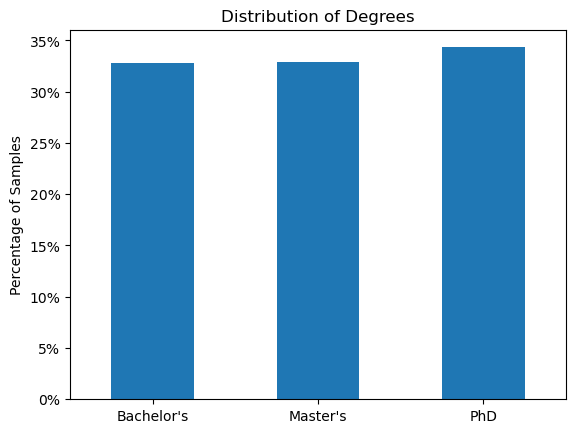

In [6]:
# create bar plot for degree in percentage
degree = ['Bachelor\'s', 'Master\'s', 'PhD']

temp_df_degree = df.groupby(by='degree').size()/df.groupby(by='degree').size().sum()
temp_df_degree.plot(kind='bar')

# rotate the x-axis labels
plt.xticks(rotation=0)

# add title and labels
plt.title('Distribution of Degrees')
plt.xlabel('')
plt.ylabel('Percentage of Samples')

plt.gca().yaxis.set_major_formatter(PercentFormatter(1, 0))

# save as png
plt.savefig('plots/degree-dist.png', dpi=300)


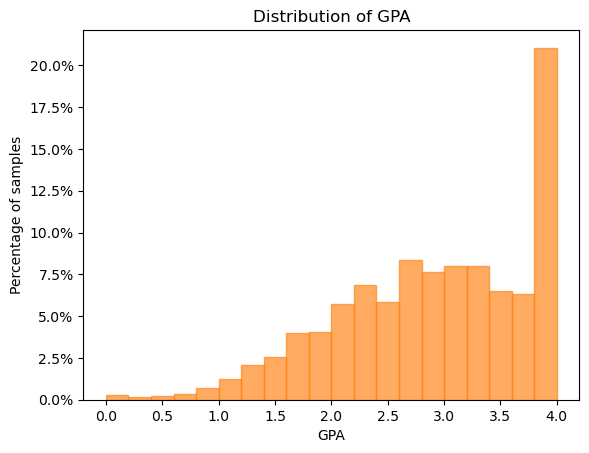

In [7]:
# show the distribution of GPA density in a histogram, remove grid and add n_bins
plt.hist(df['gpa'], weights=np.ones(len(df['gpa'])) / len(df['gpa']), 
         color='tab:orange', alpha=0.65, edgecolor='tab:orange', bins=20)

# add title and labels
plt.title('Distribution of GPA')
plt.xlabel('GPA')
plt.ylabel('Percentage of samples')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# save as png
plt.savefig('plots/gpa-dist.png', dpi=300)

## Analysis

Now that we have completed describing different features of the synthetic dataset, and drawn some insights on the distributions, we'll move on to analyzing the resume scorer and candidate evaluator models. Bearing that each distinct sample is queried 10 times, we can find a mean score and mean selection rate for each of the 4000 distinct applicants. The dataframe `dedup_df` enables such an analysis scheme.

In [8]:
df['mean_selection_rate'] = df.groupby(['group_idx'])['prediction'].transform('mean')
df['std_selection_rate'] = df.groupby(['group_idx'])['prediction'].transform(np.std)
df['mean_resume_score'] = df.groupby(['group_idx'])['resume_score'].transform('mean')
df['std_resume_score'] = df.groupby(['group_idx'])['resume_score'].transform(np.std)


dedup_df = df[['group_idx','jobref_id','school_name','gpa','degree','location','gender',
               'veteran_status','work_auth','disability','ethnicity','exp_yrs', 'num_jobs',
               'job_gap_months','job_gap_cat','mean_selection_rate','std_selection_rate',
               'mean_resume_score','std_resume_score']].drop_duplicates()

score_bins = [0,1,2,3,4,5,6,7,8,9,10]
dedup_df['mean_resume_score_bins'] = pd.cut(dedup_df['mean_resume_score'], bins=score_bins,
                                            right=False, include_lowest=True)

gpa_bins = [0,3.0,4.0001]
dedup_df['gpa_bins'] = pd.cut(dedup_df['gpa'], bins=gpa_bins, right=False, include_lowest=True)
dedup_df.head()

,group_idx,jobref_id,school_name,gpa,degree,location,gender,veteran_status,work_auth,disability,ethnicity,exp_yrs,num_jobs,job_gap_months,job_gap_cat,mean_selection_rate,std_selection_rate,mean_resume_score,std_resume_score,mean_resume_score_bins,gpa_bins
0,1-36001,5,Illinois Institute of Technology,3.09,Master's,98039,N/A,N/A,0,N/A,Pacific Islander,03-05 yr,1,0,<2 months,0.0,0.000000,5.268,2.940388,"[5, 6)","[3.0, 4.0)"
1,2-36002,5,Massachusetts Institute of Technology,2.34,PhD,47401,N/A,1,1,0,Pacific Islander,03-05 yr,1,0,<2 months,0.0,0.000000,4.471,2.876122,"[4, 5)","[0.0, 3.0)"
2,3-36003,5,Massachusetts Institute of Technology,4.00,PhD,10001,M,N/A,1,0,Asian,03-05 yr,1,0,<2 months,0.9,0.316228,5.240,3.279123,"[5, 6)","[3.0, 4.0)"
3,4-36004,5,Illinois Institute of Technology,0.00,PhD,2108,N/A,0,1,N/A,Asian,03-05 yr,1,0,<2 months,0.0,0.000000,4.851,2.988833,"[4, 5)","[0.0, 3.0)"
4,5-36005,5,National Taiwan University,1.36,Bachelor's,2108,F,N/A,1,0,Asian,03-05 yr,1,0,<2 months,0.3,0.483046,4.400,3.172052,"[4, 5)","[0.0, 3.0)"


### Gender based discrepancies


For our first insight, we saw a marked bias in the selection of female candidates and individuals who refused to divulge gender information either because they're non-binary or other personal reasons. What stands out is that the resume scores are similar, but the selection rate are vastly higher for male candidates. This is also beyond any reasonable bounds such as the $\frac{4}{5}^{\text{th}}$ rule. 

The table below highlights the same and shows that controlling for a similar sample size, while the mean resume scores, their standard deviations-- and by extension the standard errors, since group size is fixed at 10-- are very similar, the candidate evaluator model's selection rate is vastly different. The mean and median selection rates highlight this difference-- where individuals identifying as female have a 38% lower selection rate when compared to men. For those who deny sharing gender information or identify as non-binary the selection rate is 0%.

In [9]:
gender_group_df = dedup_df.groupby(['gender']).agg({'group_idx':['count'],
                                                    'mean_resume_score':['mean'],
                                                    'std_resume_score':['mean'],
                                                    'mean_selection_rate':['mean',percentile(50)]})

rename_map = {('group_idx', 'count'): 'Number of applicants',
              ('mean_resume_score', 'mean'): 'Mean resume score',
              ('std_resume_score', 'mean'): 'Std dev resume score',
              ('mean_selection_rate', 'mean'): 'Mean selection rate',
              ('mean_selection_rate', 'p50'): 'Median selection rate'}

gender_group_df.columns = [rename_map[tuple(col)] for col in gender_group_df.columns]
gender_group_df

,Number of applicants,Mean resume score,Std dev resume score,Mean selection rate,Median selection rate
gender,,,,,
F,1318,4.992102,2.830119,0.312064,0.3
M,1339,5.020466,2.848930,0.492905,0.6
N/A,1342,4.981757,2.851413,0.000000,0.0


The above analysis can also be viewed through the lens of fairness metrics covered in class. 

Let's consider the statistical parity difference (SPD)-- defined as the difference between the proportion of positive outcomes for the majority and minority groups. Mathematically,

$$\text{SPD} = \mathbb{P}(\hat{Y} = 1|A = \text{minority}) - \mathbb{P}(\hat{Y} = 1|A = \text{majority})$$

Setting the predicted outcome $\left(\hat{Y}\right)$, in the above equation, to be output of the candidate evaluator model we can see that $\mathbb{P}(\hat{Y} = 1|A = \text{minority})  = \mathbb{E}(\hat{Y}|A = \text{minority})$, since our outcome is binary. Thus, substituting the mean selection rate in the above equation, we find that: 

$$\begin{align}
\text{SPD}_{\text{f-m}} &= \mathbb{E}(\hat{Y}|\text{gender} = \text{female}) - \mathbb{E}(\hat{Y}|\text{gender} = \text{male}) \\
&= 0.312 - 0.492 = -0.18
\end{align}$$

Likewise, for non-binary individuals, we see:
$$\begin{align}
\text{SPD}_{\text{na-m}} &= \mathbb{E}(\hat{Y}|\text{gender} = \text{N/A}) - \mathbb{E}(\hat{Y}|\text{gender} = \text{male}) \\
&= 0.00 - 0.492 = -0.492
\end{align}$$

<br><br>
Disparate impact is very similar to SPD, except that it is a ratio of the above proportions as opposed to a difference. Mathematically, 
$$\text{DI} = \dfrac{\mathbb{P}(\hat{Y} = 1|A = \text{minority})}{\mathbb{P}(\hat{Y} = 1|A = \text{majority})}$$

As before, since our model is binary $\mathbb{P}(\hat Y = 1 | A = a) = \mathbb{E}(\hat Y | A = a)$, we modify the above equation with mean selection rate arrived at above, finding:

$$
\begin{align}
\text{DI}_{\text{f/m}} &= \dfrac{\mathbb{E}(\hat{Y}|\text{gender} = \text{female})}{\mathbb{E}(\hat{Y}|\text{gender} = \text{male})} \\
&= \dfrac{0.312}{0.492} = 0.634
\end{align}
$$

Similarly, for non-binary individuals:

$$
\begin{align}
\text{DI}_{\text{na/m}} &= \dfrac{\mathbb{E}(\hat{Y}|\text{gender} = \text{N/A})}{\mathbb{E}(\hat{Y}|\text{gender} = \text{male})} \\
&= \dfrac{0.00}{0.492} = 0.0
\end{align}
$$


### Job gap based discrepancies

Just as we saw with gender, we can identify a significant bias in the selection of candidates with gaps in their work history. What stands out is that while the resume scores are similar, the selection rate for candidates who have a gap of 2 or more months is 0%. 

The table below highlights the same and shows that even with a sizable sample, while the mean resume scores, their standard deviations-- and by extension the standard errors-- are very similar, the candidate evaluator model's selection rate is approximately 30% on avg, while the same for individuals with as little as a 2 month gap in their work history it is 0%.

In [10]:
job_gap_months_group_df = dedup_df.groupby(['job_gap_cat']).agg({'group_idx':['count'],
                                                    'mean_resume_score':['mean'],
                                                    'std_resume_score':['mean'],
                                                    'mean_selection_rate':['mean',percentile(50)]})

rename_map = {('group_idx', 'count'): 'Number of applicants',
              ('mean_resume_score', 'mean'): 'Mean resume score',
              ('std_resume_score', 'mean'): 'Std dev resume score',
              ('mean_selection_rate', 'mean'): 'Mean selection rate',
              ('mean_selection_rate', 'p50'): 'Median selection rate'}

job_gap_months_group_df.columns = [rename_map[tuple(col)] for col in job_gap_months_group_df.columns]
job_gap_months_group_df

,Number of applicants,Mean resume score,Std dev resume score,Mean selection rate,Median selection rate
job_gap_cat,,,,,
<2 months,3334,4.988039,2.836323,0.321326,0.3
>=2 months,665,5.048708,2.879865,0.000000,0.0


Expressing the same using some of the fairness metrics we have seen above, we can say that:

$$\begin{align}
\text{SPD}_{\text{gap}} &= \mathbb{E}(\hat{Y}|\text{gap} \text{>=2 months}) - \mathbb{E}(\hat{Y}|\text{gap} \text{<2 months}) \\
&= 0.00 - 0.321 = -0.321
\end{align}$$

Similarly with disparate impact,


$$\begin{align}
\text{DI}_{\text{gap}} &= \dfrac{\mathbb{E}(\hat{Y}|\text{gap} \text{>=2 months})}{\mathbb{E}(\hat{Y}|\text{gap} \text{<2 months})} \\
&= \dfrac{0.00}{0.321} = 0.0
\end{align}$$


### Resume score bins based discrepancy

The resume scoring model exhibited substantial variability in scores assigned to identical
profiles. This inconsistency suggests potential flaws in the model’s stability or its underlying
algorithms, leading to questions about its reliability and the fairness of the candidate assess-
ment process.

In the scatter plot below, we observe that there is no clear relationship between resume scores and the
likelihood of selection for an interview. This lack of correlation indicates that the resume
scoring model might not effectively influence the final hiring decisions and that the candidate
evaluator model holds a more significant position in the hiring process.

In [11]:
mean_resume_score_bins_group_df = dedup_df[(dedup_df['job_gap_months']<2)&
                                           (dedup_df['gender']!='N/A')].groupby(['mean_resume_score_bins']).\
agg({'group_idx':['count'],'mean_selection_rate':['mean'],'std_selection_rate':['mean']})

rename_map = {('group_idx', 'count'): 'Number of applicants',
              ('mean_selection_rate', 'mean'): 'Mean selection rate',
              ('std_selection_rate', 'mean'): 'Std dev selection rate'}

mean_resume_score_bins_group_df.columns = [rename_map[tuple(col)] for col in mean_resume_score_bins_group_df.columns]
mean_resume_score_bins_group_df

,Number of applicants,Mean selection rate,Std dev selection rate
mean_resume_score_bins,,,
"[0, 1)",0,NaN,NaN
"[1, 2)",2,0.400000,0.505046
"[2, 3)",35,0.502857,0.478690
"[3, 4)",281,0.470819,0.476708
"[4, 5)",772,0.476425,0.481352
"[5, 6)",829,0.481303,0.478266
"[6, 7)",291,0.491065,0.488232
"[7, 8)",23,0.473913,0.472361
"[8, 9)",0,NaN,NaN


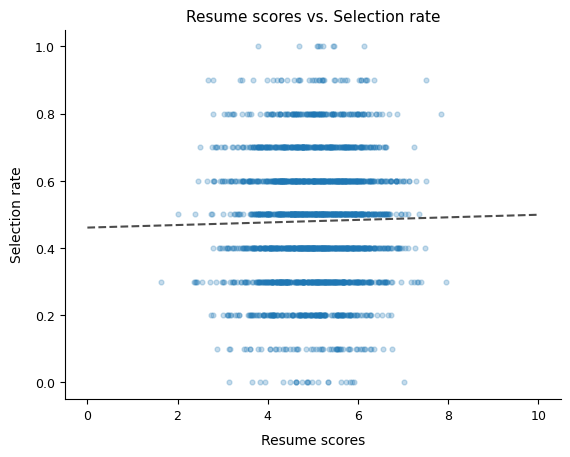

In [12]:
fig, ax = plt.subplots()

resume_score_df = dedup_df[(dedup_df['job_gap_months']<2)&
                           (dedup_df['gender']!='N/A')]

ax.scatter(x = resume_score_df['mean_resume_score'], y = resume_score_df['mean_selection_rate'], 
           s=12, alpha=0.25, c='tab:blue', marker='o')
plt.title('Resume scores vs. Selection rate',fontsize=11)
ax.set_xlabel('Resume scores',fontsize=10,labelpad=8)
ax.set_ylabel('Selection rate',fontsize=10,labelpad=8)

# setup tick values, tick labels, and axis labels
ax.tick_params(axis='both', which='major',labelsize=9)

# build trendline
m,c = np.polyfit(resume_score_df['mean_resume_score'], resume_score_df['mean_selection_rate'], deg=1)
xseq = np.linspace(0, 10, num=10000)
ax.plot(xseq, m*xseq+c, color='k', linestyle='dashed', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Interpretability with SHAP



In [13]:
rs_input_df = dedup_df[['jobref_id', 'school_name', 'gpa', 'degree', 'location', 'gender', 
                        'veteran_status', 'work_auth', 'disability', 'ethnicity', 'exp_yrs', 'job_gap_cat']].copy()

ce_input_df = dedup_df[['jobref_id', 'school_name', 'gpa', 'degree', 'location', 'gender', 
                        'veteran_status', 'work_auth', 'disability', 'ethnicity', 'exp_yrs',
                        'job_gap_cat','mean_resume_score']].copy()

def resume_scorer(input_):
    input_df = pd.DataFrame(data = input_, 
                            columns=rs_input_df.columns)
    response_df = pd.merge(left=dedup_df, right=input_df, left_index=True, right_index=True, how='right')
    return response_df['mean_resume_score'].values

def candidate_evaluator(input_):
    input_df = pd.DataFrame(data = input_, 
                            columns=ce_input_df.columns)
    response_df = pd.merge(left=dedup_df, right=input_df, left_index=True, right_index=True, how='right')
    return response_df['mean_selection_rate'].values+10**-8


Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.20it/s]


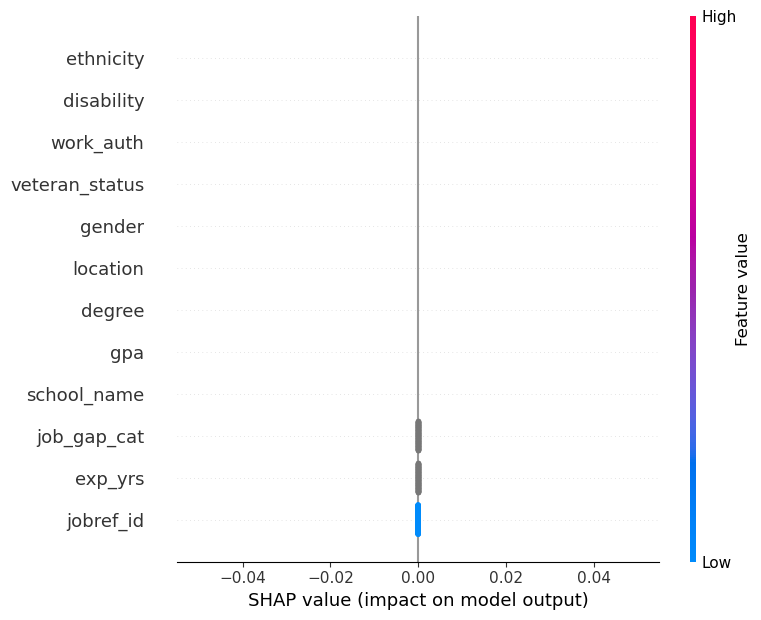

In [14]:
import warnings
warnings.filterwarnings('ignore')


sample_start = 0
sample_end = 250

rs_explainer = shap.KernelExplainer(resume_scorer, rs_input_df.iloc[sample_start:sample_end])
rs_shap_values = rs_explainer(shap.sample(rs_input_df.iloc[sample_start:sample_end]))
shap.summary_plot(rs_shap_values, show=False)
plt.savefig('plots/rs-shap.png', dpi=300)


## Appendix

### Ethnicity based discrepancies


In [15]:
ethnicity_group_df = dedup_df[(dedup_df['gender']=='M')&
                              (dedup_df['job_gap_months']<2)].groupby(['ethnicity']).\
agg({'group_idx':['count'],'mean_resume_score':['mean'],'std_resume_score':['mean'],
     'mean_selection_rate':['mean',percentile(50)],'std_selection_rate':['mean']})

rename_map = {('group_idx', 'count'): 'Number of applicants',
              ('mean_resume_score', 'mean'): 'Mean resume score',
              ('std_resume_score', 'mean'): 'Std dev resume score',
              ('mean_selection_rate', 'mean'): 'Mean selection rate',
              ('mean_selection_rate', 'p50'): 'Median selection rate',
              ('std_selection_rate', 'mean'): 'Std dev selection rate'}

ethnicity_group_df.columns = [rename_map[tuple(col)] for col in ethnicity_group_df.columns]
ethnicity_group_df

,Number of applicants,Mean resume score,Std dev resume score,Mean selection rate,Median selection rate,Std dev selection rate
ethnicity,,,,,,
Asian,203,5.011901,2.837184,0.597044,0.6,0.483473
Black,218,5.013055,2.856866,0.589450,0.6,0.487231
Native American,228,4.916417,2.870970,0.597807,0.6,0.475261
Pacific Islander,243,5.047436,2.857566,0.574897,0.6,0.490692
White,233,5.038923,2.823985,0.576395,0.6,0.490122


### Work auth based discrepancies

In [16]:
work_auth_group_df = dedup_df[(dedup_df['gender']=='M')&
                              (dedup_df['job_gap_months']<2)].groupby(['work_auth']).\
agg({'group_idx':['count'],'mean_resume_score':['mean'],'std_resume_score':['mean'],
     'mean_selection_rate':['mean',percentile(50)],'std_selection_rate':['mean']})

rename_map = {('group_idx', 'count'): 'Number of applicants',
              ('mean_resume_score', 'mean'): 'Mean resume score',
              ('std_resume_score', 'mean'): 'Std dev resume score',
              ('mean_selection_rate', 'mean'): 'Mean selection rate',
              ('mean_selection_rate', 'p50'): 'Median selection rate',
              ('std_selection_rate', 'mean'): 'Std dev selection rate'}

work_auth_group_df.columns = [rename_map[tuple(col)] for col in work_auth_group_df.columns]
work_auth_group_df

,Number of applicants,Mean resume score,Std dev resume score,Mean selection rate,Median selection rate,Std dev selection rate
work_auth,,,,,,
0,551,5.028430,2.830465,0.569873,0.6,0.488101
1,574,4.984557,2.867800,0.602787,0.6,0.482951


### Disability based discrepancies


In [17]:
disability_group_df = dedup_df[(dedup_df['gender']=='M')&
                              (dedup_df['job_gap_months']<2)].groupby(['disability']).\
agg({'group_idx':['count'],'mean_resume_score':['mean'],'std_resume_score':['mean'],
     'mean_selection_rate':['mean',percentile(50)],'std_selection_rate':['mean']})

rename_map = {('group_idx', 'count'): 'Number of applicants',
              ('mean_resume_score', 'mean'): 'Mean resume score',
              ('std_resume_score', 'mean'): 'Std dev resume score',
              ('mean_selection_rate', 'mean'): 'Mean selection rate',
              ('mean_selection_rate', 'p50'): 'Median selection rate',
              ('std_selection_rate', 'mean'): 'Std dev selection rate'}

disability_group_df.columns = [rename_map[tuple(col)] for col in disability_group_df.columns]
disability_group_df

,Number of applicants,Mean resume score,Std dev resume score,Mean selection rate,Median selection rate,Std dev selection rate
disability,,,,,,
0,386,4.907158,2.850999,0.583679,0.6,0.484858
1,362,5.063624,2.835980,0.582873,0.6,0.485724
N/A,377,5.052005,2.860990,0.593369,0.6,0.485863


### Veteran status based discrepancies


In [18]:
veteran_status_group_df = dedup_df[(dedup_df['gender']=='M')&
                              (dedup_df['job_gap_months']<2)].groupby(['veteran_status']).\
agg({'group_idx':['count'],'mean_resume_score':['mean'],'std_resume_score':['mean'],
     'mean_selection_rate':['mean',percentile(50)],'std_selection_rate':['mean']})

rename_map = {('group_idx', 'count'): 'Number of applicants',
              ('mean_resume_score', 'mean'): 'Mean resume score',
              ('std_resume_score', 'mean'): 'Std dev resume score',
              ('mean_selection_rate', 'mean'): 'Mean selection rate',
              ('mean_selection_rate', 'p50'): 'Median selection rate',
              ('std_selection_rate', 'mean'): 'Std dev selection rate'}

veteran_status_group_df.columns = [rename_map[tuple(col)] for col in veteran_status_group_df.columns]
veteran_status_group_df

,Number of applicants,Mean resume score,Std dev resume score,Mean selection rate,Median selection rate,Std dev selection rate
veteran_status,,,,,,
0,393,4.982746,2.870502,0.573028,0.6,0.488044
1,361,4.977560,2.820962,0.591136,0.6,0.483428
N/A,371,5.058445,2.855065,0.596765,0.6,0.484740


### Degree level based discrepancies


In [19]:
degree_group_df = dedup_df[(dedup_df['gender']=='M')&
                              (dedup_df['job_gap_months']<2)].groupby(['degree']).\
agg({'group_idx':['count'],'mean_resume_score':['mean'],'std_resume_score':['mean'],
     'mean_selection_rate':['mean',percentile(50)],'std_selection_rate':['mean']})

rename_map = {('group_idx', 'count'): 'Number of applicants',
              ('mean_resume_score', 'mean'): 'Mean resume score',
              ('std_resume_score', 'mean'): 'Std dev resume score',
              ('mean_selection_rate', 'mean'): 'Mean selection rate',
              ('mean_selection_rate', 'p50'): 'Median selection rate',
              ('std_selection_rate', 'mean'): 'Std dev selection rate'}

degree_group_df.columns = [rename_map[tuple(col)] for col in degree_group_df.columns]
degree_group_df

,Number of applicants,Mean resume score,Std dev resume score,Mean selection rate,Median selection rate,Std dev selection rate
degree,,,,,,
Bachelor's,348,5.032727,2.844243,0.596264,0.6,0.483550
Master's,375,4.974861,2.840213,0.588267,0.6,0.482719
PhD,402,5.012037,2.862754,0.576866,0.6,0.489707


### GPA bins based discrepancy

In [20]:
gpa_bins_group_df = dedup_df[(dedup_df['gender']=='M')&
                             (dedup_df['job_gap_months']<2)].groupby(['gpa_bins']).\
agg({'group_idx':['count'],'mean_resume_score':['mean'],'std_resume_score':['mean'],
     'mean_selection_rate':['mean',percentile(50)],'std_selection_rate':['mean']})

rename_map = {('group_idx', 'count'): 'Number of applicants',
              ('mean_resume_score', 'mean'): 'Mean resume score',
              ('std_resume_score', 'mean'): 'Std dev resume score',
              ('mean_selection_rate', 'mean'): 'Mean selection rate',
              ('mean_selection_rate', 'p50'): 'Median selection rate',
              ('std_selection_rate', 'mean'): 'Std dev selection rate'}

gpa_bins_group_df.columns = [rename_map[tuple(col)] for col in gpa_bins_group_df.columns]
gpa_bins_group_df

,Number of applicants,Mean resume score,Std dev resume score,Mean selection rate,Median selection rate,Std dev selection rate
gpa_bins,,,,,,
"[0.0, 3.0)",561,5.032278,2.862782,0.556863,0.6,0.491388
"[3.0, 4.0)",564,4.979952,2.836317,0.616312,0.6,0.479589


Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|█████████████████████████████████████████| 100/100 [00:36<00:00,  2.70it/s]


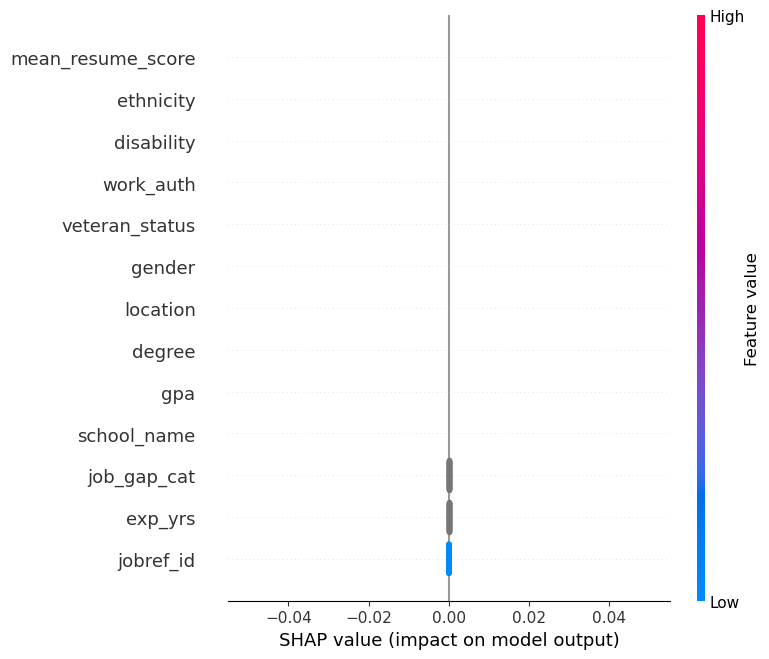

In [21]:
import warnings
warnings.filterwarnings('ignore')


ce_explainer = shap.KernelExplainer(candidate_evaluator, ce_input_df.iloc[sample_start:sample_end], link='logit')
ce_shap_values = ce_explainer(shap.sample(ce_input_df.iloc[sample_start:sample_end]))
shap.summary_plot(ce_shap_values, show=False)
plt.savefig('plots/ce-shap.png', dpi=300)